# CLASSIFY IMAGES (CIFAR-10) USING CNNs



#  PROBLEM STATEMENT

- CIFAR-10 is a dataset that consists of several images divided into the following 10 classes: 
    - Airplanes
    - Cars 
    - Birds
    - Cats
    - Deer
    - Dogs
    - Frogs
    - Horses
    - Ships
    - Trucks

- The dataset stands for the Canadian Institute For Advanced Research (CIFAR)
- CIFAR-10 is widely used for machine learning and computer vision applications. 
- The dataset consists of 60,000 32x32 color images and 6,000 images of each class.
- Images have low resolution (32x32). 
- Data Source: https://www.cs.toronto.edu/~kriz/cifar.html


#  IMPORTING LIBRARIES & DATASETS

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [26]:
from keras.datasets import cifar10
(X_train, y_train) , (X_test, y_test) = cifar10.load_data()

In [27]:
X_train.shape

(50000, 32, 32, 3)

In [28]:
X_test.shape

(10000, 32, 32, 3)

In [29]:
y_train.shape

(50000, 1)

In [30]:
y_test.shape

(10000, 1)

# VISUALIZE DATA

[1]


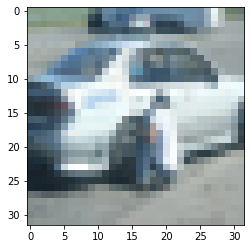

In [31]:
i = 30009
plt.imshow(X_train[i])
print(y_train[i])

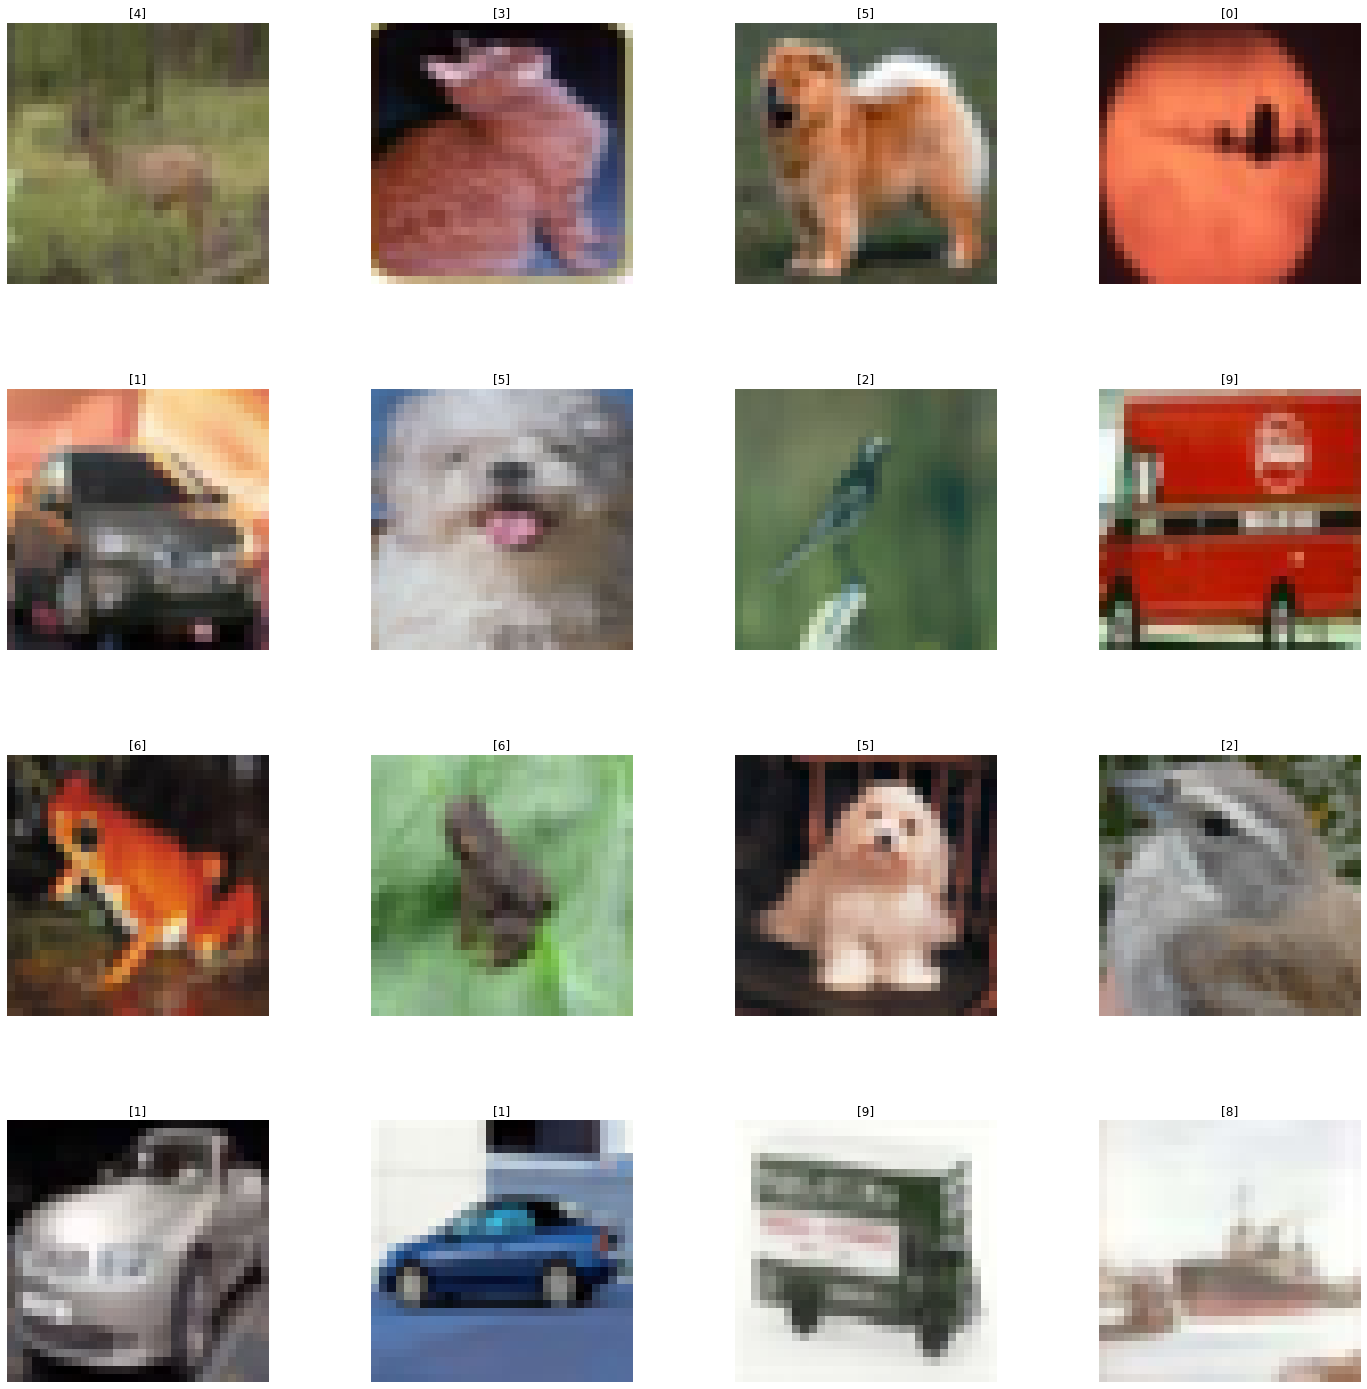

In [32]:
W_grid = 4
L_grid = 4

fig, axes = plt.subplots(L_grid, W_grid, figsize = (25, 25))
axes = axes.ravel()

n_training = len(X_train)

for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pick a random number
    axes[i].imshow(X_train[index])
    axes[i].set_title(y_train[index])
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.4)

In [33]:
n_training

50000

#  DATA PREPARATION

In [34]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [35]:
number_cat = 10

In [36]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [37]:
import keras
y_train = keras.utils.to_categorical(y_train, number_cat)

In [38]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [39]:
y_test = keras.utils.to_categorical(y_test, number_cat)

In [40]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [41]:
X_train = X_train/255
X_test = X_test/255


In [42]:
X_train

array([[[[0.23137255, 0.24313726, 0.24705882],
         [0.16862746, 0.18039216, 0.1764706 ],
         [0.19607843, 0.1882353 , 0.16862746],
         ...,
         [0.61960787, 0.5176471 , 0.42352942],
         [0.59607846, 0.49019608, 0.4       ],
         [0.5803922 , 0.4862745 , 0.40392157]],

        [[0.0627451 , 0.07843138, 0.07843138],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509805, 0.21568628],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117648, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215687, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941177, 0.19607843],
         [0.47058824, 0.32941177, 0.19607843],
         [0.42745098, 0.28627452, 0.16470589]],

        ...,

        [[0.8156863 , 0.6666667 , 0.3764706 ],
         [0.7882353 , 0.6       , 0.13333334]

In [43]:
X_train.shape

(50000, 32, 32, 3)

In [44]:
Input_shape = X_train.shape[1:]

In [45]:
Input_shape

(32, 32, 3)

# Callbacks

In [46]:
rls = ReduceLROnPlateau(monitor='val_accuracy', mode ='max', factor=0.5, min_lr=1e-7, verbose = 1, patience=10)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience=50)
mc = ModelCheckpoint('cnn_best_model.h5', monitor='val_accuracy', mode='max', verbose = 1, save_best_only=True)
callback_list = [rls, es, mc]

#  TRAINING THE MODEL

In [48]:
def build_model(lr = 0, dc = 0, dr = 0):
    model = Sequential(name = 'CNN_cifar10')
    model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='elu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(dr))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = optimizers.Adam(lr = lr, decay = dc)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [49]:
model = build_model(lr = 0.001, dc = 1e-5, dr = 0.5)
model.summary()

Model: "CNN_cifar10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        

# Data Augmentation

In [50]:
datagen = ImageDataGenerator(
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False
                            )
datagen.fit(X_train)

In [52]:
model.fit_generator(datagen.flow(X_train, y_train, batch_size = 64),
                                 validation_data = (X_test, y_test),
                                 steps_per_epoch = X_train.shape[0] // 64, 
                                 epochs = 100, 
                                 verbose = 1,
                                 callbacks = callback_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 1.8021 - accuracy: 0.4201
Epoch 00001: val_accuracy improved from -inf to 0.56190, saving model to cnn_best_model.h5
781/781 [==============================] - 304s 389ms/step - loss: 1.8021 - accuracy: 0.4201 - val_loss: 1.3190 - val_accuracy: 0.5619
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 1.2994 - accuracy: 0.5705
Epoch 00002: val_accuracy improved from 0.56190 to 0.64140, saving model to cnn_best_model.h5
781/781 [==============================] - 316s 405ms/step - loss: 1.2994 - accuracy: 0.5705 - val_loss: 1.1270 - val_accuracy: 0.6414
Epoch 3/100
781/781 [==============================] - ETA: 0s - loss: 1.1347 - accuracy: 0.6348
Epoch 00003: val_accuracy improved from 0.64140 to 0.67380, saving model to cnn_best_model.h5
781/781 [==============================] - 314s 402ms/step - loss: 1.1347 - accuracy

#  EVALUATING THE MODEL

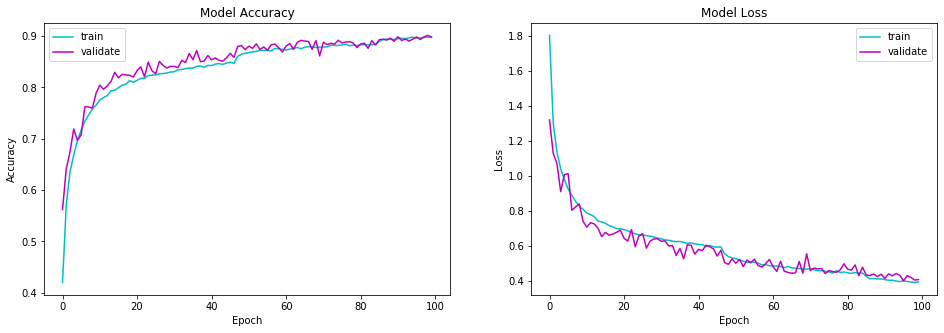

In [55]:
def plot_model(history): 
    fig, axs = plt.subplots(1,2,figsize=(16,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], 'c') 
    axs[0].plot(history.history['val_accuracy'],'m') 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].plot(history.history['val_loss'], 'm') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper right')
    plt.show()
plot_model(model.history)

In [57]:
saved_model = load_model('cnn_best_model.h5')
test_loss, test_acc = saved_model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy:', round(test_acc, 2))

313/313 [==============================] - 8s 27ms/step - loss: 0.4045 - accuracy: 0.9013
Test Accuracy: 0.9
